* Importing required python modules
* Importing my custom functions

In [1]:
# General imports
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

# My scripts imports
from scripts.scripts import ser_tpye, get_ser_sequence, diversity

* Importing the mut_df (mutation dataframe), median dataframe (won't be used here) and sequenceing tables (from sql).
* Changing types of "pos_aa" column to int and renaming values in "ab_target" column.

In [2]:
# importing datasets to python
path_input = "input"
path_output = "output"

files_input = os.listdir(path_input)
files_list = []

name_csv_dic = {'covid_vaccine_new.mut_df.csv':"mut_df",
                'new_covid_median.csv':"median",
                'covid_vaccine_new.sequences.csv':"seqs"}
                
for i in files_input:
    name = i.split(".csv")[0]
    files_list.append(name)
    globals()[name_csv_dic[i]] = pd.read_csv(path_input+"\\"+i, index_col=0)

# converting pos_aa type to int from float
# Converting ab_target values to more easier format
mut_df["pos_aa"] = mut_df["pos_aa"].astype("int")
mut_df["ab_target"] = mut_df["ab_target"].replace({'Non-Spike B':"sn", 'Spike+ Mem B':"sp"})

* Creating filters for the mut_df dataframe:
    1. Only functional clones.
    2. Only mutations in amino acid positions between 1 and 104 (inclusive).
    3. Only sample specific clones.
    4. only non-synonomous mutations.
    5. Drop "Stop" mutations.
    6. Clones with unique seqeunces greater than 1.

* Appling filters to the mut_df dataframe.
* Using custom functions to determine the type of the serine (diffrenciating between the two codons)

In [3]:
# Creating filters 
cond_func = mut_df["functional"] == 1
cond_posaa =  mut_df["pos_aa"].isin(range(1,105))
cond_sid = mut_df["sample_id"].notnull()
cond_syn = mut_df["syn"] == 0 
cond_nonstop = mut_df["to_aas"] != "*"
cond_cnt = mut_df["unique_cnt"] > 1

# filterd dataframe
filt_df = mut_df[cond_func & cond_sid  & cond_nonstop & cond_posaa & cond_cnt & cond_syn]

# correcting serine codon assosiation
for aa_t in ["from_aa", "to_aas"]:
    filt_df.loc[(filt_df[aa_t] == "S"),aa_t] = filt_df[(filt_df[aa_t] == "S")].apply(ser_tpye, target=aa_t, axis=1)
    filt_df.loc[(filt_df[aa_t]=="S*"),aa_t] = filt_df.loc[(filt_df[aa_t]=="S*"),["clone_id","pos_aa"]].apply(get_ser_sequence, seq_df=seqs[["clone_id","sequence"]], axis=1)
    filt_df = filt_df[(filt_df[aa_t] != "S*")]

* Creating germline diversity series for subjects 3 and 4

In [6]:
x = diversity(filt_df[filt_df.subject_id == 3]).diversity
y = diversity(filt_df[filt_df.subject_id == 4]).diversity

* With the germline diversity of subjects 3 and 4, compre then visually via barplot.

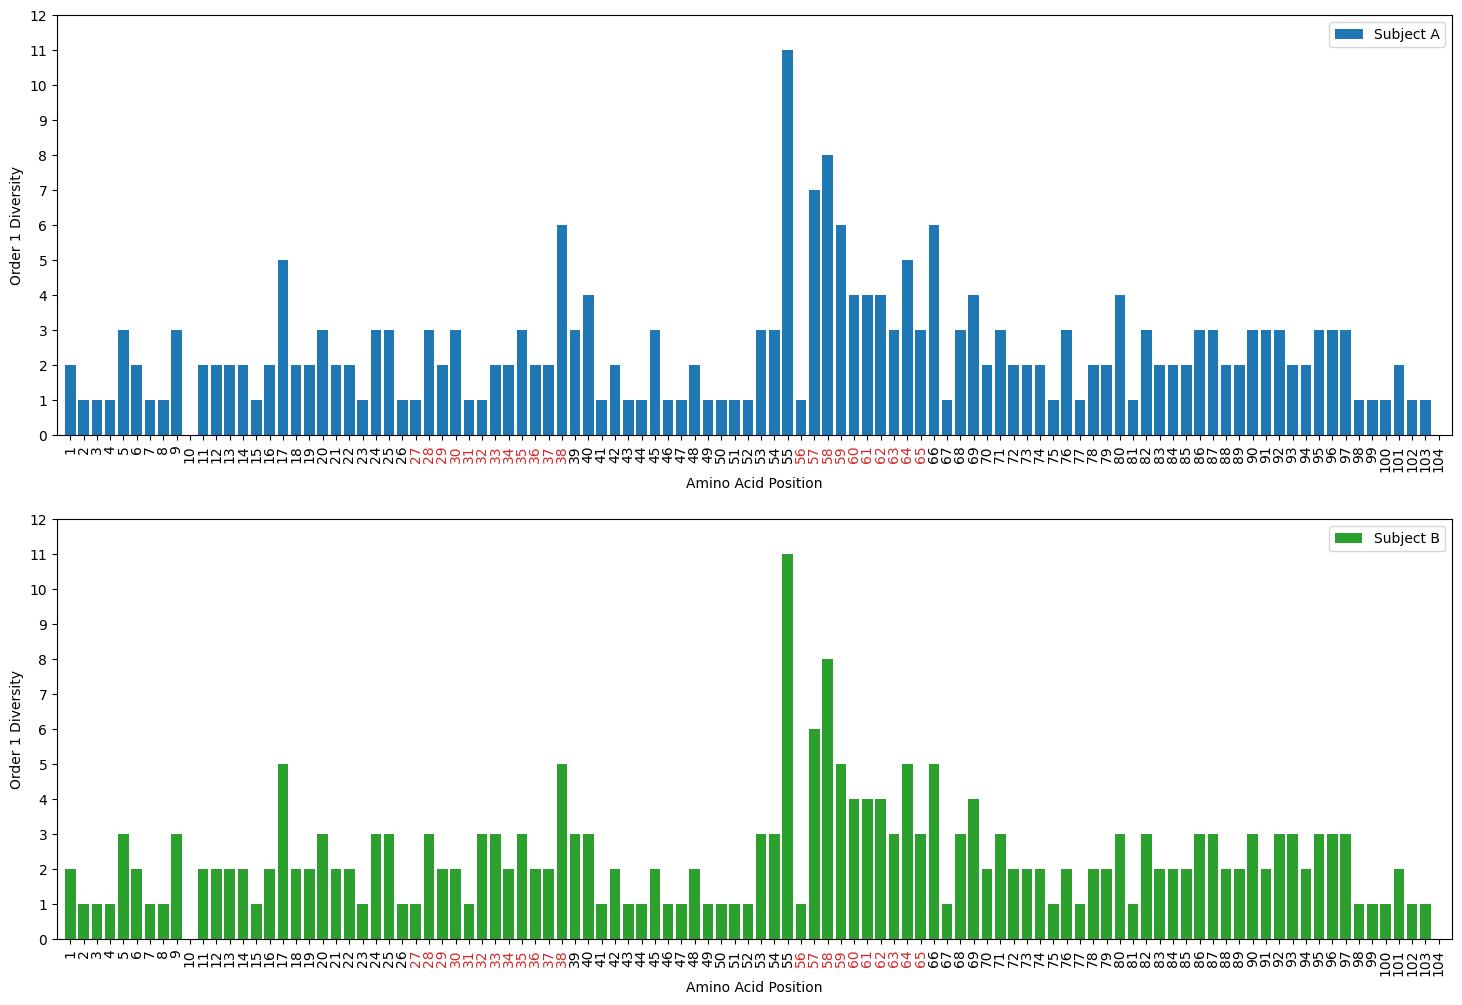

In [7]:
get_div = "germline"

if get_div == "to_aas":
    div_series = []
    for key in filt_df.subject_id.unique():
        subject = f"subject_{key}"
        cond = (filt_df.subject_id == key)
        div_subj = filt_df[cond].groupby("pos_aa").agg({"to_aas":getdiv}).reset_index()
        div_subj.rename({"to_aas":subject}, axis=1,inplace=True)
        div_series.append(div_subj)

if get_div == "germline":
    x_new = pd.DataFrame({"pos_aa":range(1,105), "subject_3":x})
    y_new = pd.DataFrame({"pos_aa":range(1,105), "subject_4":y})
    div_series = [x_new, y_new]

fig, ax = plt.subplots(2,1, figsize=(18,12))

for divsr,axs,cr, newlabel in zip(div_series[0:2], ax, ["tab:blue","tab:green"], ["Subject A", "Subject B"]):
    label_subj = divsr.columns[-1]
    axs.bar(x=divsr.pos_aa, height=divsr[label_subj], label=newlabel, color=cr)
    axs.set_xlabel("Amino Acid Position")
    axs.set_ylabel("Order 1 Diversity")
    x_range = np.arange(1,105,1)
    axs.set_xticks(x_range)
    axs.tick_params(axis='x', labelrotation=90)
    axs.set_xlim(x_range[0]-1,x_range[-1]+1)
    axs.set_yticks(np.arange(0,divsr[label_subj].max()+2,1))
    axs.set_ylim(0,divsr[label_subj].max()+1)
    axs.legend()

    range_cdr = list(range(27,39)) + list(range(56,66)) #CDR1, CDR2
    for xtick, xcolor in zip(axs.get_xticklabels(), ["tab:red" if i in range_cdr else "black" for i in divsr.pos_aa.astype("int")]):
        xtick.set_color(xcolor)

* Correlate the diversity of subject 3 and 4 (scatterplot + linear model)

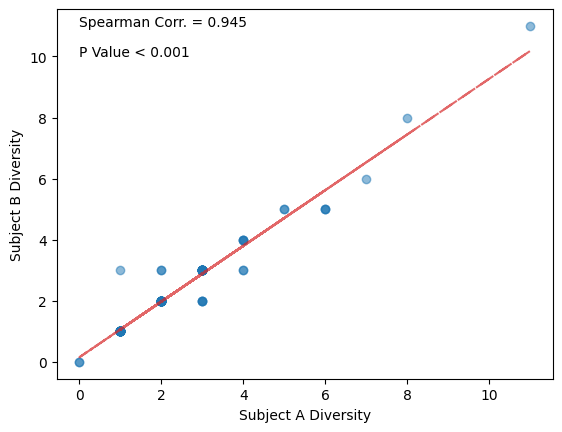

In [8]:
subjects_ab = pd.DataFrame(index=range(28,105))
for i in div_series[0:2]:
    subjects_ab = pd.concat([subjects_ab,i.set_index("pos_aa")], axis=1).fillna(0).astype("int")

plt.scatter(x=x, y=y, alpha=0.5)
plt.xlabel("Subject A Diversity")
plt.ylabel("Subject B Diversity")

spearman = spearmanr(x,y)
spearman_r = round(spearman[0],3)
spearman_pval = round(spearman[1],3)

plt.text(x=0, y=11, s=f"Spearman Corr. = {spearman_r}")
plt.text(x=0, y=10, s=f"P Value < 0.001")

coef = np.polyfit(x, y, 1)
lm = np.poly1d(coef)
plt.plot(x, lm(x), label='Linear Fit', color="tab:red", alpha=0.7, ls="-.")